Revenue Prediction
==================
In this project the goal is to predict movies revenue using their features. revenue is given by ( box_office - budget ) so the main goal is to predict box office. 

1. Prepare and preprocess the given data. 

2. After exploring data find, select and especially create new features. ignore others.

3. Prepare features to feed the model. 

4. Select and try different models.

5. Document and report each step using relative plots and a brief explanation. finally report the best suited model and justify why did it performed well.



- Keep in mind that in this task accuracy itself only has only part of score.

- Hint: to create new features you can use credit attributes. Think of it this way, what affects box office?  

**Tools** 

importing useful tools and libraries. you may use any other library as well.

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Modelling
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import plotly.express as px

import ast

In [73]:
np.random.seed(101)

In [74]:
# Your project struct must look like this,


# |── Name_SID.zip
# │   ├── data
# │   │       ├── rotten_tomatoes_5000_movies.csv
# │   │       ├── rotten_tomatoes_5000_movies.csv
# │   ├── *.ipynb
# │   ├── document.pdf

df_movies = pd.read_csv(r"data/rotten_tomatoes_5000_movies.csv")
df_credit = pd.read_csv(r"data/rotten_tomatoes_5000_credits.csv")


In [75]:
df_movies = df_movies[df_movies['rt_box_office']!=0]
y = df_movies['rt_box_office']
X = df_movies.drop(columns='rt_box_office')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

In [76]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3376 entries, 0 to 4798
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rt_production_budget     3376 non-null   int64  
 1   rt_genres                3376 non-null   object 
 2   rt_website               1396 non-null   object 
 3   rt_movie_id              3376 non-null   int64  
 4   rt_keywords              3376 non-null   object 
 5   rt_original_language     3376 non-null   object 
 6   rt_original_title        3376 non-null   object 
 7   rt_synopsis              3376 non-null   object 
 8   rt_audience_score        3376 non-null   float64
 9   rt_studios               3376 non-null   object 
 10  rt_production_countries  3376 non-null   object 
 11  rt_release_date          3376 non-null   object 
 12  rt_box_office            3376 non-null   int64  
 13  rt_runtime               3376 non-null   float64
 14  rt_languages             3376

In [77]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rt_movie_id  4803 non-null   int64 
 1   rt_title     4803 non-null   object
 2   rt_actors    4803 non-null   object
 3   rt_staff     4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [106]:
df_credit.head()

,rt_movie_id,rt_title,rt_actors,rt_staff
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [79]:
df_movies.head()

,rt_production_budget,rt_genres,rt_website,rt_movie_id,rt_keywords,rt_original_language,rt_original_title,rt_synopsis,rt_audience_score,rt_studios,rt_production_countries,rt_release_date,rt_box_office,rt_runtime,rt_languages,rt_release_status,rt_tagline,rt_title,rt_critics_score,rt_review_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124







# First Part: EDA

### Calculate the number of possible genres

In [80]:
# Safely convert the genre column
df_movies_genres = df_movies['rt_genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else []
)

# Expand the genres
all_genres = df_movies_genres.explode().dropna()

# Extract genre names
unique_genres = all_genres.apply(lambda x: x['name'] if isinstance(x, dict) else None).dropna().unique()

# Count unique genres
num_genres = len(unique_genres)

print(f"The number of unique genres is: {num_genres}")


The number of unique genres is: 19


### 1) What is the average earning of each movie genre?

In [81]:
df_genres_expanded = df_movies.copy()
df_genres_expanded['rt_genres'] = df_genres_expanded['rt_genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Expand genres into separate rows
genres_expanded = df_genres_expanded.explode('rt_genres')

# Extract genre names from the dictionary
genres_expanded['genre_name'] = genres_expanded['rt_genres'].apply(
    lambda x: x['name'] if isinstance(x, dict) else None
)

# Drop rows with invalid genre names
genres_expanded = genres_expanded.dropna(subset=['genre_name'])

# Calculate the average production budget for each genre
average_budget_by_genre = genres_expanded.groupby('genre_name')['rt_production_budget'].mean().reset_index()

# Plot the data using Plotly
fig = px.bar(
    average_budget_by_genre,
    x='genre_name',
    y='rt_production_budget',
    title='Average Production Budget by Genre',
    labels={'genre_name': 'Genre', 'rt_production_budget': 'Production Budget (USD)'},
    text='rt_production_budget'
)

# Update the chart to show text labels and format them
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(
    xaxis_title='Genre',
    yaxis_title='Average Production Budget (USD)',
    title_x=0.5,
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

# Display the chart
fig.show()

### 2) What is the share of each country in the total cost for each genre? (List the top 5 most expensive genres by country.)

In [82]:
# Create a temporary DataFrame for processing
temp_df = df_movies.copy()

# Helper functions for processing
def parse_list_column(column):
    """Convert string representation of list to actual list."""
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

def extract_dict_field(column, field_name):
    """Extract a specific field from a dictionary within a column."""
    return column.apply(lambda x: x[field_name] if isinstance(x, dict) else None)

# Parse 'rt_genres' and 'rt_production_countries' columns
temp_df['rt_genres'] = parse_list_column(temp_df['rt_genres'])
temp_df['rt_production_countries'] = parse_list_column(temp_df['rt_production_countries'])

# Expand genres and countries into separate rows
genres_expanded = temp_df.explode('rt_genres')
countries_expanded = genres_expanded.explode('rt_production_countries')

# Extract genre names and country names
countries_expanded['genre_name'] = extract_dict_field(countries_expanded['rt_genres'], 'name')
countries_expanded['country_name'] = extract_dict_field(countries_expanded['rt_production_countries'], 'name')

# Drop rows with invalid or missing data
valid_data = countries_expanded.dropna(subset=['genre_name', 'country_name'])

# Group by country and genre, calculate total production budget
country_genre_budget = (
    valid_data.groupby(['country_name', 'genre_name'])['rt_production_budget']
    .sum()
    .reset_index()
)

# Calculate the total budget for each genre
total_budget_by_genre = (
    country_genre_budget.groupby('genre_name')['rt_production_budget']
    .sum()
    .reset_index()
    .rename(columns={'rt_production_budget': 'total_genre_budget'})
)

# Merge to calculate the share of each country in the total cost of each genre
country_genre_budget = country_genre_budget.merge(
    total_budget_by_genre, on='genre_name', how='left'
)
country_genre_budget['share'] = (
    country_genre_budget['rt_production_budget'] / country_genre_budget['total_genre_budget']
) * 100

# Sort by genre budget and find the top 5 most expensive genres for each country
top_5_genres_per_country = (
    country_genre_budget.sort_values(by=['country_name', 'rt_production_budget'], ascending=[True, False])
    .groupby('country_name')
    .head(5)
)

# Plot the data
fig = px.bar(
    top_5_genres_per_country,
    x='genre_name',
    y='share',
    color='country_name',
    title='Share of Each Country in Total Cost for Top 5 Most Expensive Genres',
    labels={'genre_name': 'Genre', 'share': 'Share (%)', 'country_name': 'Country'},
    text='share'
)

# Update layout for better readability
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(
    xaxis_title='Genre',
    yaxis_title='Share in Total Cost (%)',
    title_x=0.5,
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

# Show the chart
fig.show()

### 3) Compare the number of movies produced in 3 genres over the past 10 years.

In [83]:
temp_df['rt_release_date'] = pd.to_datetime(temp_df['rt_release_date'], errors='coerce')
temp_df['release_year'] = temp_df['rt_release_date'].dt.year
temp_df['rt_release_date'] = pd.to_datetime(temp_df['rt_release_date'], errors='coerce')
temp_df = temp_df.dropna(subset=['rt_release_date'])
temp_df['release_year'] = temp_df['rt_release_date'].dt.year

In [84]:
print(temp_df['release_year'].value_counts().sort_index())

release_year
1916      1
1925      1
1927      1
1929      1
1930      1
       ... 
2012    150
2013    163
2014    143
2015    126
2016     73
Name: count, Length: 89, dtype: int64


In [85]:
# Filter movies released between 2007 and 2016
last_10_years = temp_df[temp_df['release_year'].between(2007, 2016)]

# Expand genres into separate rows
genres_expanded = last_10_years.explode('rt_genres')

# Extract genre names
genres_expanded['genre_name'] = genres_expanded['rt_genres'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Select genres for comparison
selected_genres = ['Action', 'Comedy', 'Drama']
filtered_genres = genres_expanded[genres_expanded['genre_name'].isin(selected_genres)]

# Count movies for each genre by year
genre_counts = filtered_genres.groupby(['release_year', 'genre_name']).size().reset_index(name='movie_count')

# Plot the data
import plotly.express as px

fig = px.line(
    genre_counts,
    x='release_year',
    y='movie_count',
    color='genre_name',
    title='Number of Movies Produced in Selected Genres (2007-2016)',
    labels={'release_year': 'Year', 'movie_count': 'Number of Movies', 'genre_name': 'Genre'}
)

# Update layout for better readability
fig.update_layout(
    xaxis=dict(tickmode='linear', dtick=1),
    yaxis_title='Number of Movies',
    xaxis_title='Year',
    title_x=0.5
)

fig.show()


### 4) On average, which country produces the longest and shortest movies?

In [86]:
temp_df = df_movies.copy()

# Convert the 'rt_production_countries' column to a list of dictionaries
temp_df['rt_production_countries'] = temp_df['rt_production_countries'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Expand the 'rt_production_countries' column into separate rows
countries_expanded = temp_df.explode('rt_production_countries')

# Extract country names from the dictionary
countries_expanded['country_name'] = countries_expanded['rt_production_countries'].apply(
    lambda x: x['name'] if isinstance(x, dict) else None
)

# Drop rows with invalid or missing data
countries_expanded = countries_expanded.dropna(subset=['country_name', 'rt_runtime'])

# Group by country and calculate the average runtime
average_runtime_by_country = countries_expanded.groupby('country_name')['rt_runtime'].mean().reset_index()

# Find the country with the longest and shortest average runtime
longest_runtime_country = average_runtime_by_country.loc[average_runtime_by_country['rt_runtime'].idxmax()]
shortest_runtime_country = average_runtime_by_country.loc[average_runtime_by_country['rt_runtime'].idxmin()]

# Print the results
print(f"The country with the longest movies on average is: {longest_runtime_country['country_name']} "
      f"({longest_runtime_country['rt_runtime']:.2f} minutes).")

print(f"The country with the shortest movies on average is: {shortest_runtime_country['country_name']} "
      f"({shortest_runtime_country['rt_runtime']:.2f} minutes).")

The country with the longest movies on average is: Singapore (172.00 minutes).
The country with the shortest movies on average is: Monaco (84.00 minutes).


In [87]:
fig = px.box(
    countries_expanded,
    x='country_name',
    y='rt_runtime',
    title='Distribution of Movie Runtimes by Country',
    labels={'rt_runtime': 'Runtime (minutes)', 'country_name': 'Country'},
    points='all'  # Show all data points
)

# Update layout for better readability
fig.update_layout(
    xaxis_title='Country',
    yaxis_title='Runtime (minutes)',
    title_x=0.5
)

fig.show()


### 5) Apart from English, what are the most frequently used languages in movies?

In [88]:
# Create a temporary DataFrame for processing
temp_df = df_movies.copy()

# Helper function to parse list of dictionaries in a column
def parse_list_column(column):
    """Convert string representation of list to actual list."""
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Parse the 'rt_languages' column
temp_df['rt_languages'] = parse_list_column(temp_df['rt_languages'])

# Expand the languages into separate rows
languages_expanded = temp_df.explode('rt_languages')

# Extract the language names from the dictionaries
languages_expanded['language_name'] = languages_expanded['rt_languages'].apply(
    lambda x: x['name'] if isinstance(x, dict) else None
)

# Drop rows with missing or invalid languages
languages_expanded = languages_expanded.dropna(subset=['language_name'])

# Exclude English
non_english_languages = languages_expanded[languages_expanded['language_name'] != 'English']

# Count the occurrences of each language
language_counts = non_english_languages['language_name'].value_counts().reset_index()
language_counts.columns = ['language_name', 'movie_count']

# Display the top 10 most frequently used languages
print("Top 10 Most Frequently Used Languages (Excluding English):")
print(language_counts.head(10))

# Plot a pie chart for the top 10 languages
fig = px.pie(
    language_counts.head(10), 
    values='movie_count', 
    names='language_name',
    title='Top 10 Most Frequently Used Languages in Movies (Excluding English)',
    hole=0.4  # To create a donut chart (optional)
)

# Show the chart
fig.show()

Top 10 Most Frequently Used Languages (Excluding English):
  language_name  movie_count
0      Français          316
1       Español          281
2       Deutsch          184
3       Pусский          153
4      Italiano          146
5           日本語           83
6           普通话           82
7       العربية           56
8     Português           49
9         Latin           43


### 6) In the past 10 years, what has been the average annual cost of the film industry in the United States? (with a yearly breakdown) HANDLE NAN

In [92]:
# Create a temporary DataFrame for processing
temp_df = df_movies.copy()

# Convert the release date column to datetime and extract the release year
temp_df['rt_release_date'] = pd.to_datetime(temp_df['rt_release_date'], errors='coerce')
temp_df = temp_df.dropna(subset=['rt_release_date'])  # Drop rows with invalid release dates
temp_df['release_year'] = temp_df['rt_release_date'].dt.year

# Helper function to parse a list of dictionaries in a column
def parse_list_column(column):
    """Convert string representation of list to actual list."""
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Parse the 'rt_production_countries' column
temp_df['rt_production_countries'] = parse_list_column(temp_df['rt_production_countries'])

# Expand the production countries into separate rows
countries_expanded = temp_df.explode('rt_production_countries')

# Extract country names from the dictionaries
countries_expanded['country_name'] = countries_expanded['rt_production_countries'].apply(
    lambda x: x['name'] if isinstance(x, dict) else None
)

# Filter data for movies produced in the United States
us_movies = countries_expanded[countries_expanded['country_name'] == 'United States of America']

# Determine the minimum and maximum years in the dataset
min_year = us_movies['release_year'].min()
max_year = us_movies['release_year'].max()

# Group by release year and calculate the average production budget
yearly_cost = (
    us_movies.groupby('release_year')['rt_production_budget']
    .mean()
    .reset_index()
    .rename(columns={'rt_production_budget': 'average_production_budget'})
)

# Ensure all years within the range are represented, filling missing years with NaN
all_years = pd.DataFrame({'release_year': range(min_year, max_year + 1)})
yearly_cost = all_years.merge(yearly_cost, on='release_year', how='left')


In [93]:
# Display the yearly breakdown
print("Average Annual Cost of the Film Industry in the United States (From Minimum to Maximum Year):")
print(yearly_cost)


Average Annual Cost of the Film Industry in the United States (From Minimum to Maximum Year):
     release_year  average_production_budget
0            1916               3.859070e+05
1            1917                        NaN
2            1918                        NaN
3            1919                        NaN
4            1920                        NaN
..            ...                        ...
96           2012               5.285788e+07
97           2013               5.560493e+07
98           2014               5.154135e+07
99           2015               5.357456e+07
100          2016               6.679701e+07

[101 rows x 2 columns]


Bar Chart

In [91]:
# Plot the yearly breakdown
fig = px.bar(
    yearly_cost,
    x='release_year',
    y='average_production_budget',
    title='Average Annual Cost of the Film Industry in the United States (Full Year Range)',
    labels={'release_year': 'Year', 'average_production_budget': 'Average Production Budget (USD)'},
    text='average_production_budget'
)

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(
    xaxis=dict(tickmode='linear', dtick=1),
    yaxis_title='Average Production Budget (USD)',
    xaxis_title='Year',
    title_x=0.5
)

fig.show()

Area Chart

In [90]:
fig = px.area(
    yearly_cost,
    x='release_year',
    y='average_production_budget',
    title='Average Annual Cost of the Film Industry in the United States (Full Year Range)',
    labels={'release_year': 'Year', 'average_production_budget': 'Average Production Budget (USD)'}
)

fig.update_layout(
    xaxis=dict(tickmode='linear', dtick=5),  # Show ticks every 5 years
    yaxis_title='Average Production Budget (USD)',
    xaxis_title='Year',
    title_x=0.5
)

fig.show()


Line Chart

In [71]:
fig = px.line(
    yearly_cost,
    x='release_year',
    y='average_production_budget',
    title='Average Annual Cost of the Film Industry in the United States (Full Year Range)',
    labels={'release_year': 'Year', 'average_production_budget': 'Average Production Budget (USD)'}
)

fig.update_traces(mode="lines+markers")  # Add markers for better readability
fig.update_layout(
    xaxis=dict(tickmode='linear', dtick=5),  # Show ticks every 5 years for better readability
    yaxis_title='Average Production Budget (USD)',
    xaxis_title='Year',
    title_x=0.5
)

fig.show()


### 7) Compare the cost trend for other countries over the past 10 years (excluding the U.S.). NOT DONE - BUGGY

In [94]:
# Create a temporary DataFrame for processing
temp_df = df_movies.copy()

# Convert the release date column to datetime and extract the release year
temp_df['rt_release_date'] = pd.to_datetime(temp_df['rt_release_date'], errors='coerce')
temp_df = temp_df.dropna(subset=['rt_release_date'])  # Drop rows with invalid release dates
temp_df['release_year'] = temp_df['rt_release_date'].dt.year

# Helper function to parse a list of dictionaries in a column
def parse_list_column(column):
    """Convert string representation of list to actual list."""
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Parse the 'rt_production_countries' column
temp_df['rt_production_countries'] = parse_list_column(temp_df['rt_production_countries'])

# Expand the production countries into separate rows
countries_expanded = temp_df.explode('rt_production_countries')

# Extract country names from the dictionaries
countries_expanded['country_name'] = countries_expanded['rt_production_countries'].apply(
    lambda x: x['name'] if isinstance(x, dict) else None
)

# Exclude the United States
non_us_movies = countries_expanded[countries_expanded['country_name'] != 'United States of America']

# Filter movies released in the past 10 years
current_year = pd.Timestamp.now().year
non_us_movies_last_10_years = non_us_movies[non_us_movies['release_year'].between(current_year - 10, current_year)]

# Group by release year and country, calculate the average production budget
yearly_cost_non_us = (
    non_us_movies_last_10_years.groupby(['release_year', 'country_name'])['rt_production_budget']
    .mean()
    .reset_index()
    .rename(columns={'rt_production_budget': 'average_production_budget'})
)

# Plot the data
fig = px.line(
    yearly_cost_non_us,
    x='release_year',
    y='average_production_budget',
    color='country_name',
    title='Average Annual Cost of the Film Industry (Excluding U.S.) Over the Past 10 Years',
    labels={'release_year': 'Year', 'average_production_budget': 'Average Production Budget (USD)', 'country_name': 'Country'}
)

fig.update_traces(mode="lines+markers")  # Add markers for better visibility
fig.update_layout(
    xaxis=dict(tickmode='linear', dtick=1),  # Show yearly ticks
    yaxis_title='Average Production Budget (USD)',
    xaxis_title='Year',
    title_x=0.5
)

fig.show()

### 8) What movies has Johnny Depp acted in?

In [95]:
# Create a temporary DataFrame for processing
temp_df = df_credit.copy()

# Helper function to parse the 'rt_actors' column
def parse_list_column(column):
    """Convert string representation of list to actual list."""
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Parse the 'rt_actors' column
temp_df['rt_actors'] = parse_list_column(temp_df['rt_actors'])

# Filter for movies where Johnny Depp appears in the 'rt_actors' column
johnny_depp_movies = temp_df[temp_df['rt_actors'].apply(
    lambda actors: any(actor['name'] == 'Johnny Depp' for actor in actors if isinstance(actor, dict))
)]

# Select relevant columns to display
johnny_depp_movies = johnny_depp_movies[['rt_title', 'rt_movie_id']]

# Display the result
print("Movies Johnny Depp has acted in:")
print(johnny_depp_movies)

Movies Johnny Depp has acted in:
                                               rt_title  rt_movie_id
1              Pirates of the Caribbean: At World's End          285
12           Pirates of the Caribbean: Dead Man's Chest           58
13                                      The Lone Ranger        57201
17          Pirates of the Caribbean: On Stranger Tides         1865
32                                  Alice in Wonderland        12155
105                     Alice Through the Looking Glass       241259
117                   Charlie and the Chocolate Factory          118
133                                        Dark Shadows        62213
178                                               Rango        44896
199   Pirates of the Caribbean: The Curse of the Bla...           22
280                                      Public Enemies        11322
295                                         The Tourist        37710
333                                       Transcendence       157353
4

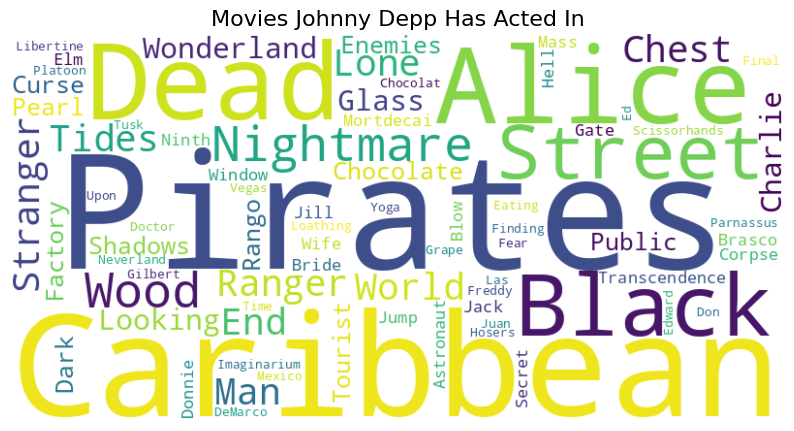

In [ ]:
from wordcloud import WordCloud

# Generate a word cloud for Johnny Depp's movies
movie_titles = " ".join(johnny_depp_movies['rt_title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(movie_titles)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Movies Johnny Depp Has Acted In", fontsize=16)
plt.show()


### 9) On average, what percentage of lead roles (top 5 in movies) are played by men and what percentage by women?

In [101]:
# Create a temporary DataFrame for analysis
temp_df = df_credit.copy()

# Parse the 'rt_actors' column into lists of dictionaries without modifying the dataset
temp_df['parsed_actors'] = temp_df['rt_actors'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Expand actors into separate rows
actors_expanded = temp_df.explode('parsed_actors')

# Extract gender and order information from the parsed actors
actors_expanded['gender'] = actors_expanded['parsed_actors'].apply(
    lambda x: x['gender'] if isinstance(x, dict) else None
)
actors_expanded['order'] = actors_expanded['parsed_actors'].apply(
    lambda x: x['order'] if isinstance(x, dict) else None
)

# Filter for lead roles (top 5 by order)
lead_roles = actors_expanded[actors_expanded['order'] < 5]

# Calculate the percentage of male and female lead roles
gender_distribution = lead_roles['gender'].value_counts(normalize=True) * 100

# Map gender codes to meaningful labels
gender_labels = {1: 'Female', 2: 'Male', 0: 'Unknown'}
gender_distribution.index = gender_distribution.index.map(gender_labels)



In [102]:
# Print the results
print("Average Percentage of Lead Roles by Gender:")
print(gender_distribution)

Average Percentage of Lead Roles by Gender:
gender
Male       58.909232
Female     31.300499
Unknown     9.790270
Name: proportion, dtype: float64


In [103]:
# Visualize the data with a pie chart
fig = px.pie(
    names=gender_distribution.index,
    values=gender_distribution.values,
    title='Average Percentage of Lead Roles by Gender',
    labels={'value': 'Percentage', 'index': 'Gender'}
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### 10) Compare the age distribution of male and female actors. (PROBLEMATIC)

In [ ]:
# Create a temporary DataFrame for analysis
temp_df = df_credit.copy()

# Parse the 'rt_actors' column into lists of dictionaries without modifying the dataset
temp_df['parsed_actors'] = temp_df['rt_actors'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Expand actors into separate rows
actors_expanded = temp_df.explode('parsed_actors')

# Extract gender and birth year information from the parsed actors
actors_expanded['gender'] = actors_expanded['parsed_actors'].apply(
    lambda x: x['gender'] if isinstance(x, dict) else None
)
actors_expanded['birth_year'] = actors_expanded['parsed_actors'].apply(
    lambda x: x.get('birth_year') if isinstance(x, dict) and 'birth_year' in x else None
)

# Calculate age (assuming the current year is known or from the dataset)
current_year = pd.Timestamp.now().year
actors_expanded['age'] = actors_expanded['birth_year'].apply(
    lambda x: current_year - x if pd.notnull(x) else None
)

# Filter out rows without valid ages
actors_expanded = actors_expanded.dropna(subset=['age', 'gender'])

# Map genders to meaningful labels
gender_labels = {1: 'Female', 2: 'Male', 0: 'Unknown'}
actors_expanded['gender'] = actors_expanded['gender'].map(gender_labels)

# Plot the age distribution by gender
fig = px.histogram(
    actors_expanded,
    x='age',
    color='gender',
    barmode='overlay',
    nbins=30,
    title='Age Distribution of Male and Female Actors',
    labels={'age': 'Age', 'gender': 'Gender'}
)

fig.update_layout(
    xaxis_title='Age',
    yaxis_title='Count',
    title_x=0.5
)

fig.show()


### 11) What are the most popular genres of movies in the past 10 years? (Once based on the number of reviews and once based on the critics' scores.) (SHOULD BE RECHECKED)

In [107]:
# Step 1: Create a temporary DataFrame for analysis
temp_df = df_movies.copy()

# Step 2: Parse the 'rt_genres' column into lists of dictionaries
temp_df['rt_genres'] = temp_df['rt_genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Step 3: Expand the genres into separate rows
genres_expanded = temp_df.explode('rt_genres')

# Step 4: Extract the genre names
genres_expanded['genre_name'] = genres_expanded['rt_genres'].apply(
    lambda x: x['name'] if isinstance(x, dict) else None
)

# Step 5: Filter for movies released in the past 10 years
genres_expanded['release_year'] = pd.to_datetime(genres_expanded['rt_release_date'], errors='coerce').dt.year
current_year = pd.Timestamp.now().year
genres_expanded = genres_expanded[genres_expanded['release_year'].between(current_year - 10, current_year)]

# Step 6: Group data by genre and calculate popularity metrics
# Based on the number of reviews
reviews_popularity = genres_expanded.groupby('genre_name')['rt_review_count'].sum().reset_index()
reviews_popularity = reviews_popularity.sort_values(by='rt_review_count', ascending=False)

# Based on critics' scores
critics_popularity = genres_expanded.groupby('genre_name')['rt_critics_score'].mean().reset_index()
critics_popularity = critics_popularity.sort_values(by='rt_critics_score', ascending=False)

# Step 7: Plot the data

# Plot 1: Popular genres based on the number of reviews
fig_reviews = px.bar(
    reviews_popularity,
    x='genre_name',
    y='rt_review_count',
    title='Most Popular Genres (Based on Number of Reviews - Past 10 Years)',
    labels={'genre_name': 'Genre', 'rt_review_count': 'Number of Reviews'},
    text='rt_review_count'
)
fig_reviews.update_traces(textposition='outside')
fig_reviews.update_layout(
    xaxis_title='Genre',
    yaxis_title='Number of Reviews',
    title_x=0.5
)

# Plot 2: Popular genres based on critics' scores
fig_critics = px.bar(
    critics_popularity,
    x='genre_name',
    y='rt_critics_score',
    title='Most Popular Genres (Based on Critics\' Scores - Past 10 Years)',
    labels={'genre_name': 'Genre', 'rt_critics_score': 'Average Critics\' Score'},
    text='rt_critics_score'
)
fig_critics.update_traces(textposition='outside')
fig_critics.update_layout(
    xaxis_title='Genre',
    yaxis_title='Average Critics\' Score',
    title_x=0.5
)

# Show the plots
fig_reviews.show()
fig_critics.show()

# Second Part: Movie Revenue Prediction

## Data Preparation

## Creating New Features

## Training

## Evaluation

## Conclusion